# Scaling the 2d Acoustic Wave Equation

This notebook shows a scaling method for the 2d acoustic wave equation which relies on dimensional analysis and the fundamental physical parameters of the problem. We will define units that allow for computation in half precision.

In [1]:
# import dependencies
import devito as dv
import numpy as np
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource
import matplotlib.pyplot as plt

The previous scaling procedure was based on the method described by Fabien-Ouellet in the 2020 work 'Seismic modeling and inversion using half-precision floating-point numbers'. This paper solved a coupled set of equations and employed a scaling method that leveraged this coupling, essentially scaling one equation down and the other up so they cancelled out. As this problem doesn't have this coupling, the method described in Ouellet 2020 does not carry over directly.

For this problem, we look to define units such that $\Delta t^2 V_{max}^2 \approx 1$. This removes the over/underflow risk from the computation. 

The stencil for this problem remains the same: $P^{n+1} = 2P^n - P^{n-1} + V_{max}^2 \Delta t^2 \nabla ^2 P$, the source term is dealt with separately in the computation

### Defining new units for space and time for a constant velocity model

The simulation works on a 2000mx2000m grid with 200 grid points in each direction, as a result of this we define a new spatial unit of 10m rather than the standard SI unit of 1m for length. This is the natural spatial unit of the problem.

Using the natural spatial unit, we redefine the maximum velocity $V_{max}$ as 300(10m)/s, as opposed to the initial value of 3000 m/s

We can then find the value of $\Delta t$ that this yields to define a new time unit. 

Using the CFL condition $ \Delta t = \frac{c \Delta x}{V_{max}}$ where $c$ is the Courant number taken to equal 1 with $\Delta x = 1 a$ and $V_{max}$ = 300(10m)/s, we find $\Delta t = \frac{1}{300}$ s

Using a $\Delta t$ of $\frac{1}{300}$ s, we can define a new time unit of $\frac{1}{300}$ s, rather than the standard SI unit of 1s for time. 

Applying both the natural spatial and new time units to our parameters allows us to redefine $V_{max}$ and $\Delta t$ such that they are both approximately equal to 1. 

Our $V_{max}$ of 300(10m)/s becomes 1(10m)/($\frac{1}{300}$ s), and using this value in the CFL condition leads to a $\Delta t$ of $c$ ($\frac{1}{300}$ s) where $c$ is the Courant number.

We must also redefine the source frequency using the new time unit, leading to $f$ = 0.1Hz, as the initial value was 30Hz and this is a per second unit (i.e. $f$ is now equal to 0.1Hz / ($\frac{1}{300}$ s), or 30Hz/s)

Below is the implementation of this new unit scheme, producing a similar output image to the unscaled 2d acoustic wave equation. Note that since $V_{max}$ = 1 and $\Delta t$ = $c$ which will always be less than or equal to 1, the $V_{max}^2 \Delta t^2$ in our update equation will never cause an under/overflow as it will always be less than equal to 1. In the implementation below, it is equal to 0.36 as the Courant number is 0.6.

Operator `Kernel` ran in 0.01 s


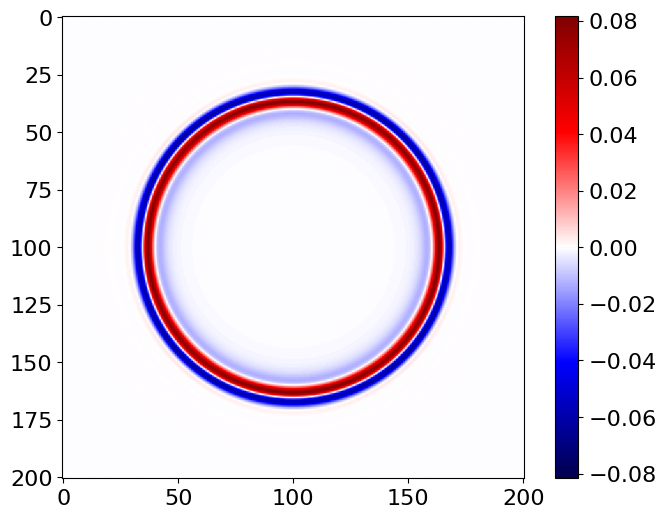

In [2]:
# new grid using the natural spatial unit of 10m, so the original extent of 2000x2000 becomes 200x200
new_extent = (200, 200)
new_shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
scaled_grid = dv.Grid(extent=new_extent, shape=new_shape, dimensions=(x, z))

# defining a pressure field
p = dv.TimeFunction(name='P', grid=scaled_grid, space_order=4, time_order=2)

# defining our velocity and timestep as required
# if our velocity is 300 10m/s, dx=1 10m (use min spacing), dt is given by the CFL condition with these values
vmax = 1
dt = (0.6)*np.amin(scaled_grid.spacing)/vmax
# apply new time unit to the start and end times
t0 = 0
tn = 0.25*300
new_time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term using the new time range
src = RickerSource(name='src', grid=scaled_grid, f0=0.1, npoint=1, time_range=new_time_range)
# setting source to the middle of the physical extent of the grid
src.coordinates.data[:] = [100, 100]
# injecting the source term to the new pressure field
src_si = src.inject(field=p.forward, expr=src)

# defining our stencil
stencil_s = dv.Eq(p.forward, 2*p - p.backward + vmax**2*dt**2*p.laplace)

# create new operator
op_s = dv.Operator([stencil_s] + src_si)

# call new operator
op_s()

# show output 
vmax = np.amax(np.abs(p.data[0]))
plt.imshow(p.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

### Defining new units for space and time for a variable velocity model

In the example above, we were able to deal with our velocity relatively easily as the model was constant so there was only one (maximum) velocity. In practice, this is rarely the case, so here we deal with a four layer velocity model as seen below.

<img src="velocity_model.png" alt="Velocity Model" style="width:500px;"/>




